In [2]:
import pandas as pd
import glob,os
import numpy as np
import pandas as pd 
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import tensorflow as tf
%matplotlib inline

In [4]:
mypath = r'../COVID-19/csse_covid_19_data/csse_covid_19_time_series'


In [6]:
def get_all_time_series(mypath):
    #path = r'../COVID-19/csse_covid_19_data/csse_covid_19_time_series'
    all_files = glob.glob(os.path.join(mypath, "*.csv"))
    for i in [0,3,4]:
        file = all_files[i]
        df = pd.read_csv(file)
        #confirmed_all = dict()
        if i==0:
            df_confirmed = pd.DataFrame()
            for row in df.values:
                df_confirmed[row[1]] = row[4:]
        if i==3:
            df_recovered = pd.DataFrame()
            for row in df.values:
                df_recovered[row[1]] = row[4:]
        if i==4:
            df_deaths = pd.DataFrame()
            for row in df.values:
                df_deaths[row[1]] = row[4:]
    df_infected = df_confirmed - df_deaths - df_recovered
    return [df_infected,df_confirmed,df_recovered,df_deaths]

In [8]:
[df_infected,df_confirmed,df_recovered,df_deaths] = get_all_time_series(mypath)
us_infected = df_infected['US'].values
us_deaths = df_deaths['US'].values
us_recovered = df_recovered['US'].values

In [10]:
us_population = 327200000;
Regr = 70;

In [12]:
def solve_SIRD_discrete(num_times,beta_t,gamma_t,mu_t,s0,i0,r0,d0):
    S = []
    I = []
    R = []
    D = []

    S.append(us_population-1.)
    I.append(1.)
    R.append(0.)
    D.append(0.)
    num_times = len(beta_t)

    for i in range(num_times-1):
        Snew = S[i] - beta_t[i]/us_population * S[i]*I[i]
        Inew = I[i] + beta_t[i]/us_population * S[i]*I[i] - gamma_t[i]*I[i] - mu_t[i]*I[i]
        Rnew = R[i] + gamma_t[i]* I[i]
        Dnew = D[i] + mu_t[i]* I[i]
        S.append(Snew)
        I.append(Inew)
        R.append(Rnew)
        D.append(Dnew)
    return [S,I,R,D]

In [14]:
i0 = us_infected[0]
r0 = 0
s0 = us_population - i0
#R1 = 3./100.
d0 = us_deaths[0]
num_times = len(us_deaths)

beta = 0.6345301162187955
gamma = 0.43979856466213035
mu = 0.006641658374541129

beta_0 = np.array([beta for i in range(num_times)])
gamma_0 = np.array([gamma for i in range(num_times)])
mu_0 = np.array([mu for i in range(num_times)])


print("beta={}\ngamma={}\nmu={}".format(beta,gamma,mu))

beta=0.6345301162187955
gamma=0.43979856466213035
mu=0.006641658374541129


In [16]:
@tf.function()
def tf_loss_fn_us(y_true, y_pred):
    beta_t = y_pred[0][:,0]
    gamma_t = y_pred[0][:,1]
    mu_t = y_pred[0][:,2]
    
    beta_0 = y_true[0][0,0]
    gamma_0 = y_true[0][0,1]
    mu_0 = y_true[0][0,2]
    
    S = []
    I = []
    R = []
    D = []

    S.append(s0)
    I.append(i0)
    R.append(r0)
    D.append(d0)
    num_times = len(beta_t)

    for i in range(num_times-1):
        Snew = S[i] - beta_t[i]/us_population * S[i]*I[i]
        Inew = I[i] + beta_t[i]/us_population * S[i]*I[i] - gamma_t[i]*I[i] - mu_t[i]*I[i]
        Rnew = R[i] + gamma_t[i]* I[i]
        Dnew = D[i] + mu_t[i]* I[i]
        S.append(Snew)
        I.append(Inew)
        R.append(Rnew)
        D.append(Dnew)
        
    I = tf.stack(I)
    D = tf.stack(D)
    epsilon = 0.000001
    Ed1 = tf.math.reduce_sum((tf.math.log((x_trains[0][:,0]+epsilon))-tf.math.log((I+epsilon)))**2 + (tf.math.log((x_trains[0][:,1]+epsilon))-tf.math.log((D+epsilon)))**2)
    
    Ed2 = 0.01*tf.math.log(tf.math.reduce_max(x_trains[0][:,0])+epsilon)/(tf.math.reduce_max(x_trains[0][:,0])+epsilon) * tf.math.reduce_sum((x_trains[0][:,0]-I)**2+ (x_trains[0][:,1]-D)**2)

    sumr = 0
    for it in range(num_times-1):
        sumr = sumr + (beta_t[it]-beta_t[it+1])**2 + (gamma_t[it]-gamma_t[it+1])**2 + 100*(mu_t[it]-mu_t[it+1])**2
    Er = 100*tf.math.log(tf.math.reduce_max(x_trains[0][:,0])+epsilon)/tf.math.reduce_max([beta_0,gamma_0,mu_0])*sumr
    
    E0 = 100*tf.math.log(tf.math.reduce_max(x_trains[0][:,0])+epsilon)/tf.math.reduce_max([beta_0,gamma_0,mu_0])*((beta_t[0]-beta_0)**2+(gamma_t[0]- gamma_0)**2 +100*(mu_t[0]-mu_0)**2)

    return Ed1+Ed2+Er+E0

In [18]:
num_times = len(us_deaths)

In [20]:
def to_float(x):
    return float(x)

to_float_vec = np.vectorize(to_float)

In [22]:
x_train = to_float_vec(np.array([us_infected[0:num_times],us_deaths[0:num_times]]).transpose())
num_times = len(x_train)

In [24]:
x_trains = to_float_vec(np.array([x_train]))

In [26]:
num_times

239

In [28]:
tf.keras.backend.set_floatx('float64')

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(num_times, 2)),
    tf.keras.layers.Dense(16,activation='sigmoid'),
    tf.keras.layers.Dense(num_times*3,activation = 'sigmoid'),
    tf.keras.layers.Reshape((num_times, 3))
])

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.012),
              loss = 'mean_squared_error',
              metrics=['accuracy']
             )

In [32]:
num_times = num_times
y_true = np.zeros((num_times,3))
y_true[:,0] = beta_0[0:num_times]
y_true[:,1] = gamma_0[0:num_times]
y_true[:,2] = mu_0[0:num_times]

y_trues = np.array([y_true])

In [34]:
model.fit(x_trains,y_trues,verbose=1,epochs=2500)

00
Epoch 2314/2500
1/1 [==============================] - 0s 574us/step - loss: 1.6231e-07 - accuracy: 1.0000
Epoch 2315/2500
1/1 [==============================] - 0s 508us/step - loss: 1.4469e-07 - accuracy: 1.0000
Epoch 2316/2500
1/1 [==============================] - 0s 541us/step - loss: 1.5761e-07 - accuracy: 1.0000
Epoch 2317/2500
1/1 [==============================] - 0s 501us/step - loss: 5.0503e-08 - accuracy: 1.0000
Epoch 2318/2500
1/1 [==============================] - 0s 487us/step - loss: 4.9117e-08 - accuracy: 1.0000
Epoch 2319/2500
1/1 [==============================] - 0s 593us/step - loss: 9.5016e-08 - accuracy: 1.0000
Epoch 2320/2500
1/1 [==============================] - 0s 539us/step - loss: 9.6540e-08 - accuracy: 1.0000
Epoch 2321/2500
1/1 [==============================] - 0s 1ms/step - loss: 1.0056e-07 - accuracy: 1.0000
Epoch 2322/2500
1/1 [==============================] - 0s 617us/step - loss: 6.1301e-08 - accuracy: 1.0000
Epoch 2323/2500
1/1 [===============

In [36]:
model(np.array([x_train]))[0]

<tf.Tensor: shape=(239, 3), dtype=float64, numpy=
array([[0.63453012, 0.43979856, 0.00664166],
       [0.63453012, 0.43979856, 0.00664166],
       [0.63453012, 0.43979856, 0.00664167],
       [0.63453012, 0.43979856, 0.00664166],
       [0.63453012, 0.43979856, 0.00664167],
       [0.63453012, 0.43979096, 0.00664166],
       [0.63453012, 0.43979856, 0.00664166],
       [0.63453012, 0.43979856, 0.00664167],
       [0.63453012, 0.43979856, 0.00664169],
       [0.63453012, 0.43979856, 0.00664166],
       [0.63453012, 0.43979856, 0.00664167],
       [0.63453012, 0.43979856, 0.00664167],
       [0.63453012, 0.43979856, 0.00664166],
       [0.63453012, 0.43979856, 0.00664167],
       [0.63453012, 0.43979856, 0.00664167],
       [0.63453012, 0.43979856, 0.00664166],
       [0.63453012, 0.43979856, 0.00664167],
       [0.63453012, 0.43979856, 0.00664166],
       [0.63453012, 0.43979856, 0.00664166],
       [0.63453012, 0.43979856, 0.00664167],
       [0.63453012, 0.43979856, 0.00664167],
     

In [38]:
tf.config.experimental_run_functions_eagerly(False)

In [40]:
images = x_trains
labels = y_trues

In [42]:
def train_step(images, labels):
    with tf.GradientTape() as tape:
        logits = model(x_trains, training=True)
    
        # Add asserts to check the shape of the output.
        #tf.debugging.assert_equal(logits.shape, (32, 10))
    
        loss_value = loss_object(labels, logits)
    loss_history.append(loss_value)
    grads = tape.gradient(loss_value, model.trainable_variables)
    #print(grads)
    optimizer.apply_gradients(zip(grads, model.trainable_variables),experimental_aggregate_gradients=True)


In [44]:
def train(epochs):
    for epoch in range(epochs):
        train_step(images, labels)
        print ('Epoch {} finished'.format(epoch))


In [46]:
loss_history = []

In [95]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000005)
loss_object = tf_loss_fn_us
train(epochs =5000)
np_loss_history = []
for loss in loss_history:
    np_loss_history.append(loss.numpy())

Epoch 4000 finished
Epoch 4001 finished
Epoch 4002 finished
Epoch 4003 finished
Epoch 4004 finished
Epoch 4005 finished
Epoch 4006 finished
Epoch 4007 finished
Epoch 4008 finished
Epoch 4009 finished
Epoch 4010 finished
Epoch 4011 finished
Epoch 4012 finished
Epoch 4013 finished
Epoch 4014 finished
Epoch 4015 finished
Epoch 4016 finished
Epoch 4017 finished
Epoch 4018 finished
Epoch 4019 finished
Epoch 4020 finished
Epoch 4021 finished
Epoch 4022 finished
Epoch 4023 finished
Epoch 4024 finished
Epoch 4025 finished
Epoch 4026 finished
Epoch 4027 finished
Epoch 4028 finished
Epoch 4029 finished
Epoch 4030 finished
Epoch 4031 finished
Epoch 4032 finished
Epoch 4033 finished
Epoch 4034 finished
Epoch 4035 finished
Epoch 4036 finished
Epoch 4037 finished
Epoch 4038 finished
Epoch 4039 finished
Epoch 4040 finished
Epoch 4041 finished
Epoch 4042 finished
Epoch 4043 finished
Epoch 4044 finished
Epoch 4045 finished
Epoch 4046 finished
Epoch 4047 finished
Epoch 4048 finished
Epoch 4049 finished


In [96]:
np_loss_history[-5:]

[4817.8106160638845,
 4817.718843122773,
 4817.627045539995,
 4817.535216242518,
 4817.443356896541]

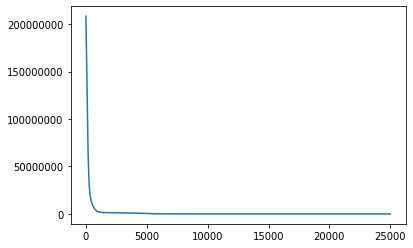

<Figure size 432x288 with 0 Axes>

In [97]:
ax = plt.gca()
plt.plot(np.arange(0,len(np_loss_history),1),np_loss_history)

ax.get_yaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)
plt.show()
plt.savefig('loss_fn_232')

In [98]:
[Sr,Ir,Rr,Dr]= solve_SIRD_discrete(num_times,model.predict(x_trains)[0][:,0],model.predict(x_trains)[0][:,1],model.predict(x_trains)[0][:,2],s0,i0,r0,d0)

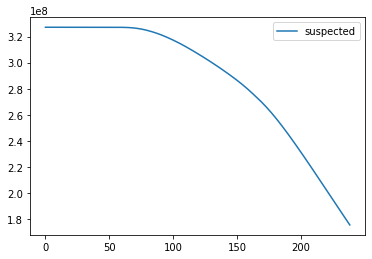

In [99]:
plt.plot(np.arange(num_times),Sr,label="suspected")
plt.legend()

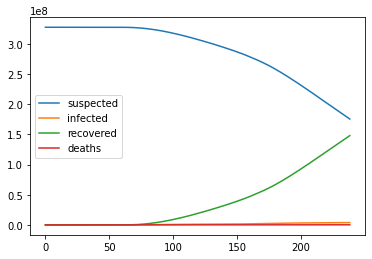

In [100]:
plt.plot(np.arange(num_times),Sr,label="suspected")
plt.plot(np.arange(num_times),Ir,label="infected")
plt.plot(np.arange(num_times),Rr,label="recovered")
plt.plot(np.arange(num_times),Dr,label="deaths")
plt.legend()

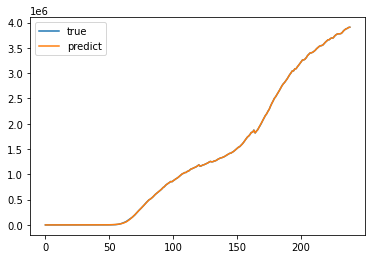

In [101]:
plt.plot(np.arange(0,num_times,1),x_trains[0][:,0],label='true')
plt.plot(np.arange(0,num_times,1),Ir,label='predict')
plt.legend()

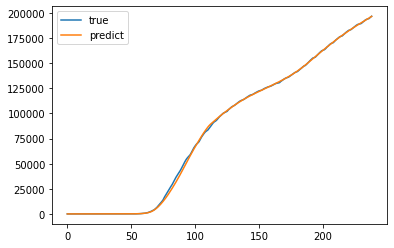

In [102]:
plt.plot(np.arange(0,num_times,1),x_trains[0][:,1],label='true')
plt.plot(np.arange(0,num_times,1),Dr,label='predict')
plt.legend()

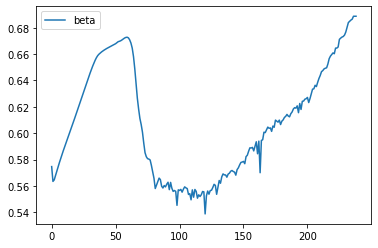

In [103]:
plt.plot(np.arange(0,num_times,1),model.predict(x_trains)[0][:,0],label='beta')
plt.legend()

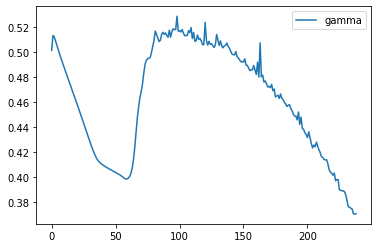

In [104]:
plt.plot(np.arange(0,num_times,1),model.predict(x_trains)[0][:,1],label='gamma')
plt.legend()

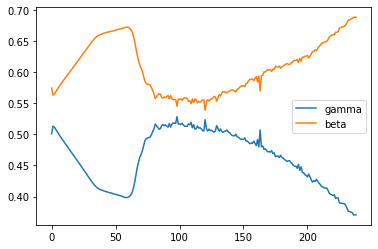

In [105]:
plt.plot(np.arange(0,num_times,1),model.predict(x_trains)[0][:,1],label='gamma')
plt.legend()
plt.plot(np.arange(0,num_times,1),model.predict(x_trains)[0][:,0],label='beta')
plt.legend()

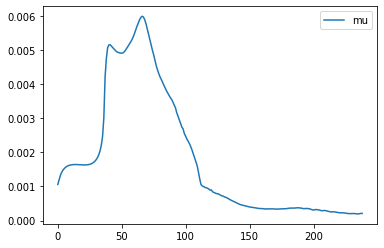

In [106]:
plt.plot(np.arange(0,num_times,1),model.predict(x_trains)[0][:,2],label='mu')
plt.legend()

In [108]:
model.save('2020_09_17_run')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: 2020_09_17_run/assets


1